### Preprocessing

scRNA-Seq of Placental explants

In [1]:
import numpy as np
import pandas as pd
import scanpy as sc
import matplotlib.pyplot as plt
import matplotlib
import os
import sys
%matplotlib inline
import seaborn as sns
import seaborn as sb
from glob import iglob
import anndata
import matplotlib as mpl
import skmisc
import gc

    
sc.settings.verbosity = 1  # verbosity: errors (0), warnings (1), info (2), hints (3)
sc.settings.figdir = './results/'
sc.logging.print_versions()
sc.settings.set_figure_params(dpi=80)  # low dpi (dots per inch) yields small inline figures

sys.executable


fig_path= './results/'

-----
anndata     0.7.5
scanpy      1.7.1
sinfo       0.3.1
-----
PIL                 8.1.2
anndata             0.7.5
anyio               NA
attr                20.3.0
babel               2.9.0
backcall            0.2.0
brotli              NA
cairo               1.20.0
certifi             2020.12.05
cffi                1.14.5
chardet             4.0.0
cloudpickle         1.6.0
colorama            0.4.4
cycler              0.10.0
cython_runtime      NA
cytoolz             0.11.0
dask                2021.03.1
dateutil            2.8.1
decorator           4.4.2
fsspec              0.8.7
get_version         2.1
google              NA
h5py                3.1.0
idna                2.10
igraph              0.8.3
ipykernel           5.5.0
ipython_genutils    0.2.0
ipywidgets          7.6.3
jedi                0.18.0
jinja2              2.11.3
joblib              1.0.1
json5               NA
jsonschema          3.2.0
jupyter_server      1.4.1
jupyterlab_server   2.3.0
kiwisolver          1.3.1


In [2]:
def Barplot(which_var, adata, var='identity', height=3, color = False, suffix= ''):
    
    '''
    Function to plot barplots plotting the proportion of cells per catergory in var, coming from each category in which_var.
    
    Parameters:
        which_var: column name in .obs. Contains the categories to contrast.
        adata: anndata object.
        var: column name in .obs. It contains the categories of the cells.
        height: plot height
        color: colors to use
        suffix: string. Suffix to be added at the end of the name of the plot.
    
    Return:
        Saves bar plot as a pdf.
        
    '''
    
    plotdata = pd.crosstab(adata.obs[var], adata.obs[which_var], normalize='index') * 100
    if 'category' in plotdata.index.dtype.name:
        plotdata.index.reorder_categories(adata.obs[var].cat.categories[::-1])

    if not color:
        ax1 = plotdata.plot.barh(stacked = True, edgecolor = 'none', zorder = 3, figsize = (6,height), fontsize = 14, grid = False)
    else:
        ax1 = plotdata.plot.barh(stacked = True, edgecolor = 'none', zorder = 3, figsize = (6,height), fontsize = 14, grid = False, color = color)
    ax1.set_title(which_var+' %')
    ax1.set_ylabel(var)
    horiz_offset = 1
    vert_offset = 1.
    ax1 = ax1.legend(bbox_to_anchor = (horiz_offset, vert_offset))
    ax1.figure.savefig(str(sc.settings.figdir)+'/barplot_'+var+'_proportions_'+which_var+ suffix+'.pdf', bbox_inches='tight',
                       dpi=300, orientation='landscape', format= 'pdf', optimize=True)

### Import data

In [3]:
adata = sc.read('./data/rna1_counts_Tg_adata.h5ad')

In [4]:
set(adata.obs["batch"])

{'0', '1', '2', '3'}

#### Correcting batch numbers for concatenation
As the batch numbers are repeated between infections, I will modify them. The order will be Lm= 0-7. Pf= 8-19. Tg= 20-27

### Subsetting only the Hs genes

In [5]:
#Keeping hs genes only
 # from the previous notebook: adata.var['hs'] = adata.var.gene_ids.str.startswith('ENSG') ## all human genes

In [6]:
# Extracting the list of Hs genes:
hsGenes= list(adata.var.loc[adata.var['hs'] == True].index)

In [7]:
# Subsetting Hs genes:
adata= adata[:, hsGenes].copy()

/opt/conda/lib/python3.8/site-packages/pandas/core/arrays/categorical.py:2487: FutureWarning: The `inplace` parameter in pandas.Categorical.remove_unused_categories is deprecated and will be removed in a future version.
  res = method(*args, **kwargs)


In [8]:
adata

AnnData object with n_obs × n_vars = 67814 × 36601
    obs: 'sample', 'stage', 'donor', 'hpi', 'infection', 'percent_mito', 'n_counts', 'batch', 'scrublet_score', 'scrublet_cluster_score', 'zscore', 'bh_pval', 'bonf_pval', 'is_doublet', 'infection_stage', 'S_score', 'G2M_score', 'phase', 'n_genes_by_counts', 'total_counts', 'total_counts_hs', 'pct_counts_hs', 'total_counts_tg', 'pct_counts_tg', 'Tg_infected'
    var: 'gene_ids', 'feature_types', 'mean', 'std', 'hs', 'tg', 'n_cells_by_counts', 'mean_counts', 'pct_dropout_by_counts', 'total_counts'
    uns: 'infection_colors'
    layers: 'raw_counts'

In [9]:
#removing the extra columns in .var corresponding to the Tg preprocessing
adata.var= adata.var.drop(columns=['tg','hs','n_cells_by_counts', 'mean_counts','pct_dropout_by_counts','total_counts'])

In [10]:
gc.collect()

685

# QC plots

As a first step we will just remove those cells that are definitely not useful:

In [11]:
## Deleting the cells expressing less than 10 genes
sc.pp.filter_cells(adata, min_genes=10)
print('Total number of cells: {:d}'.format(adata.n_obs))

Total number of cells: 67814


In [12]:
#sc.set_figure_params(figsize=(20,10))

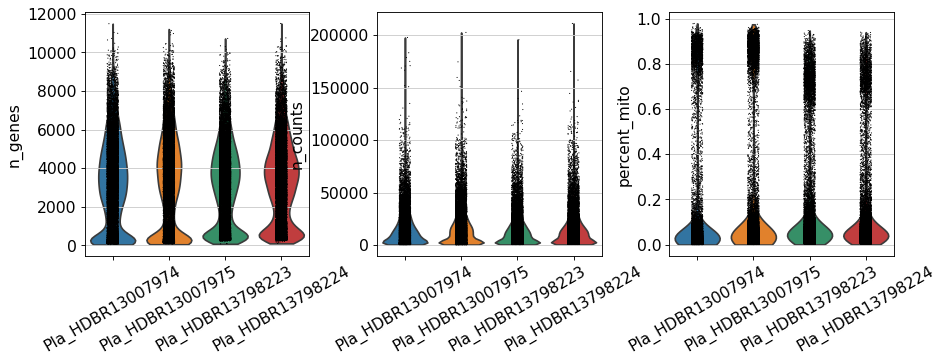

In [13]:
sc.pl.violin(adata, ['n_genes', 'n_counts','percent_mito'], groupby='sample', rotation=30, save='_before_qc.pdf', wspace=10) 

In [14]:
#sc.set_figure_params(figsize=(6.4,4.8))

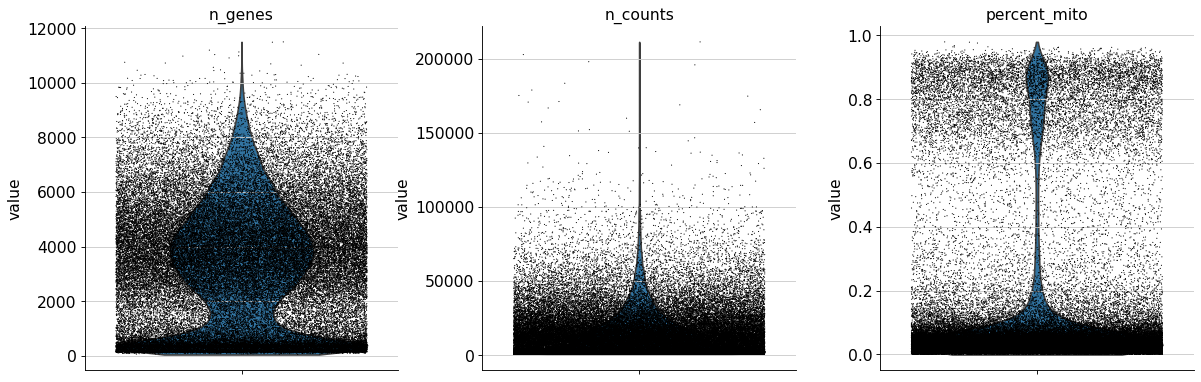

In [15]:
sc.pl.violin(adata, ['n_genes', 'n_counts', 'percent_mito'],jitter=0.4, multi_panel=True, save='.pdf')

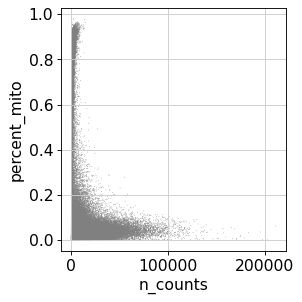

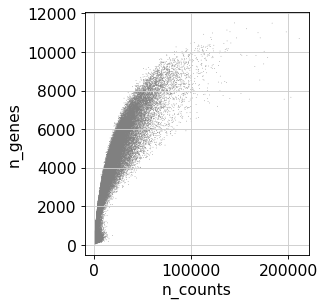

In [16]:
sc.pl.scatter(adata, x='n_counts', y='percent_mito', save='_numi_vs_mito.pdf')
sc.pl.scatter(adata, x='n_counts', y='n_genes', save='_numi_vs_ngenes.pdf')

### Filtering the number of genes

In [17]:
sc.set_figure_params(figsize=(6.4,4.8))

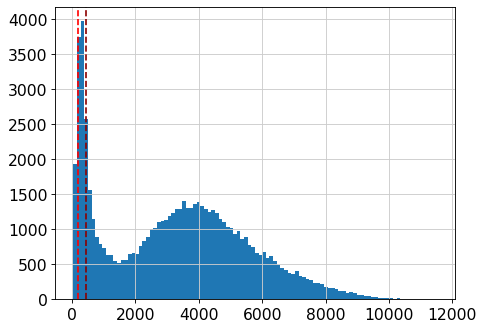

In [18]:
plt.hist(adata.obs['n_genes'], bins = 100)
plt.axvline(200, linestyle = '--', color = 'red')
plt.axvline(450, linestyle = '--', color = 'darkred')

In [19]:
#deleting the cells expressing less than 450 genes
sc.pp.filter_cells(adata, min_genes=450)

/opt/conda/lib/python3.8/site-packages/pandas/core/arrays/categorical.py:2487: FutureWarning: The `inplace` parameter in pandas.Categorical.remove_unused_categories is deprecated and will be removed in a future version.
  res = method(*args, **kwargs)


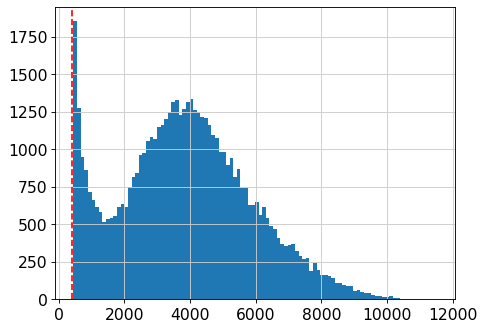

In [20]:
plt.hist(adata.obs['n_genes'], bins = 100)
plt.axvline(400, linestyle = '--', color = 'red')

In [21]:
print('Total number of cells: {:d}'.format(adata.n_obs))
print('Total number of genes: {:d}'.format(adata.n_vars))
#adata.obs['donor_souporcell'].values.describe()
adata.obs['sample'].values.describe()

Total number of cells: 56582
Total number of genes: 36601


,counts,freqs
categories,,
Pla_HDBR13007974,13100,0.231522
Pla_HDBR13007975,13849,0.244760
Pla_HDBR13798223,14657,0.259040
Pla_HDBR13798224,14976,0.264678



### Filter cells by counts

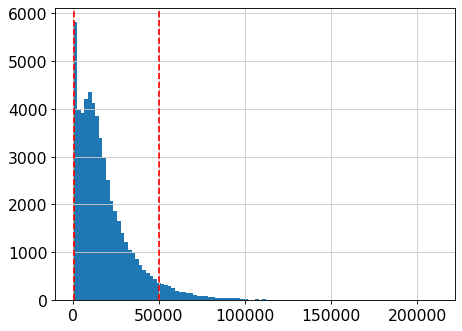

In [22]:
plt.hist(adata.obs['n_counts'], bins = 100)
plt.axvline(1000, linestyle = '--', color = 'red')
plt.axvline(50000, linestyle = '--', color = 'red')

In [23]:
sc.pp.filter_cells(adata, min_counts = 1000)
print('Number of cells after min count filter: {:d}'.format(adata.n_obs))

/opt/conda/lib/python3.8/site-packages/pandas/core/arrays/categorical.py:2487: FutureWarning: The `inplace` parameter in pandas.Categorical.remove_unused_categories is deprecated and will be removed in a future version.
  res = method(*args, **kwargs)


Number of cells after min count filter: 55146


In [24]:
print('Total number of cells: {:d}'.format(adata.n_obs))
print('Total number of genes: {:d}'.format(adata.n_vars))

Total number of cells: 55146
Total number of genes: 36601



### Filter cells with large % mitochondrial genes

In [25]:
sc.set_figure_params(figsize=(6.5,4.8))

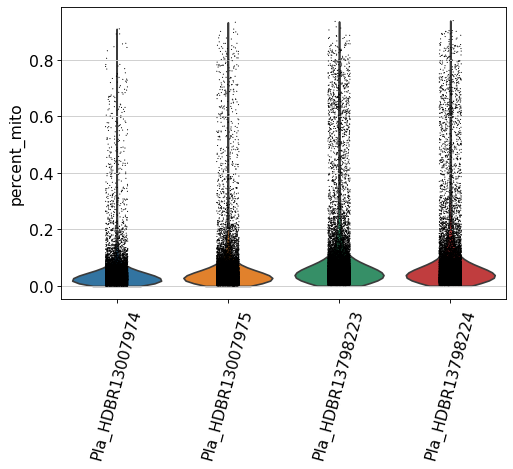

In [26]:
sc.pl.violin(adata, ['percent_mito'], groupby='sample', rotation=75 ) #

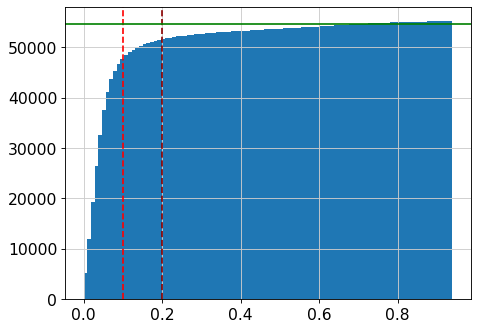

In [27]:
#Histogram Y number of cells, X mitocondrial percentage
plt.hist(adata.obs['percent_mito'], bins = 100, cumulative=True)
plt.axvline(0.1, linestyle = '--', color = 'red')
plt.axvline(0.2, linestyle = '--', color = 'darkred')
plt.axhline(adata.n_obs*0.99, linestyle = '-', color = 'green')

In [28]:
# Keeping cells with <20%
adata = adata[adata.obs['percent_mito'] < 0.2, :]

/opt/conda/lib/python3.8/site-packages/pandas/core/arrays/categorical.py:2487: FutureWarning: The `inplace` parameter in pandas.Categorical.remove_unused_categories is deprecated and will be removed in a future version.
  res = method(*args, **kwargs)


In [29]:
print('Total number of cells: {:d}'.format(adata.n_obs))
print('Total number of genes: {:d}'.format(adata.n_vars))
adata.obs['donor'].values.describe()
pd.DataFrame(adata.obs).to_csv(str(sc.settings.figdir)+'/metadata_filtered.csv')

Total number of cells: 51491
Total number of genes: 36601


#### Q5: What is the threshold percentage of mitochondrial counts used to retain cells?

In [30]:
print('Threshold of % mitochodrial counts: 20%')

Threshold of % mitochodrial counts: 20%



### Saving raw counts

In [47]:
adata.write('../data/rna1_counts_preprocessed_adata.h5ad')